In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, shape
import geopandas as gpd
import pickle

# Import custom functions from `scripts` folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from scripts.clean_tweets import geometrize_tweets, convert_shapefile_crs, find_frequencies
from scripts.home_location import assign_home_location

np.random.seed(42)
pd.set_option('display.max_columns', 999)

# Loading data

In [3]:
ba12 = pd.read_csv('../data/tweets/ba_2012.csv')

/scratch/public/jsp/twitter-and-displacement/.env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
ba_shapefiles = gpd.read_file('../data/shapefiles/buenos_aires_shapefiles/BA_2010.shp')
ba_shapefiles = convert_shapefile_crs(ba_shapefiles)

# Filtering data and adding tracts

In [21]:
# Compute summary stats
num_tweets_12, num_users_12, median_tweets_12 = len(ba12), ba12['u_id'].nunique(), ba12.groupby('u_id').size().median()

In [22]:
# Filter based on median tweets for 2012
ba12_filtered = ba12.groupby('u_id').filter(lambda group: len(group) >= median_tweets_12)

In [ ]:
# Geometrize tweets based on lat/lon
ba12_filtered = geometrize_tweets(ba12_filtered)

In [ ]:
# Add datetime
ba12_filtered['timestamp'] = pd.to_datetime(ba12_filtered['created_at'] // 1000, unit='s')
ba12_filtered['date'] = ba12_filtered['timestamp'].dt.date
ba12_filtered['hour'] = ba12_filtered['timestamp'].dt.hour

In [ ]:
# Spatial join for tracts; add home locations
ba12_filtered = gpd.sjoin(ba12_filtered, ba_shapefiles, how='left', op='intersects')
ba12_filtered['home'] = assign_home_location(ba12_filtered, tract='codigo')

In [2]:
# Save data for easy loading in future
# with open('../data/ba12_home.pkl', 'wb') as file:
#     pickle.dump(ba12_filtered, file, protocol=4)
with open('../data/ba12_home.pkl', 'rb') as file:
    ba12_filtered = pickle.load(file)


ba12_filtered['is_home'] = ba12_filtered['home'] == ba12_filtered['codigo']

In [6]:
# How many of the filtered tweets have a home assignment?
print((~ba12_filtered['home'].isnull()).mean())

0.2510007870144685


In [23]:
# Ratio of users that have home location
ba12_filtered.groupby(['u_id']).first()['is_home'].mean()

0.04158327774071603

In [8]:
# Ratio of filtered 2012 tweets in which tweet was made from home tract 
ba12_filtered['is_home'].mean()

0.1126735967745134

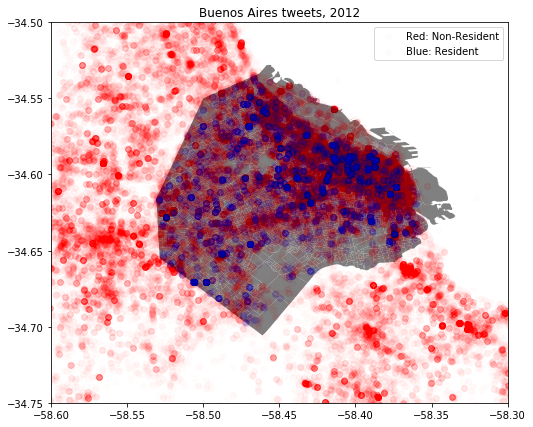

In [20]:
### Plot 5% of 2012 tweets
# Blue tweets: Resident
# Red tweets: Non-resident
# Gray (barely visible beneath the blue): Buenos Aires shapefile
fig, ax = plt.subplots(figsize=(10, 7))
ba_shapefiles['geometry'].plot(ax=ax, color='gray')
smpl = ba12_filtered.sample(frac=0.05, random_state=42)
smpl[~smpl['is_home']].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Non-Resident')
smpl[smpl['is_home']].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Resident')
plt.legend()
plt.axis([-58.6, -58.3, -34.75, -34.5])
plt.title('Buenos Aires tweets, 2012');

# min_hours == 0

In [3]:
# Save data for easy loading in future
# with open('../data/ba12_home.pkl', 'wb') as file:
#     pickle.dump(ba12_filtered, file, protocol=4)
with open('../data/ba12_home.pkl', 'rb') as file:
    ba12_filtered = pickle.load(file)

ba12_filtered['home'] = assign_home_location(ba12_filtered, tract='codigo', min_hours=0)
ba12_filtered['is_home'] = ba12_filtered['home'] == ba12_filtered['codigo']

In [4]:
# How many of the filtered tweets have a home assignment?
print((~ba12_filtered['home'].isnull()).mean())

0.27685890360804255


In [5]:
# Ratio of users that have home location
ba12_filtered.groupby(['u_id']).first()['is_home'].mean()

0.04741432559978257

In [6]:
# Ratio of filtered 2012 tweets in which tweet was made from home tract 
ba12_filtered['is_home'].mean()

0.11921064135907543

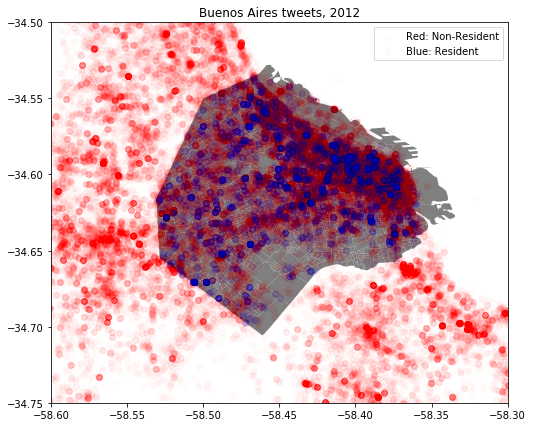

In [7]:
### Plot 5% of 2012 tweets
# Blue tweets: Resident
# Red tweets: Non-resident
# Gray (barely visible beneath the blue): Buenos Aires shapefile
fig, ax = plt.subplots(figsize=(10, 7))
ba_shapefiles['geometry'].plot(ax=ax, color='gray')
smpl = ba12_filtered.sample(frac=0.05, random_state=42)
smpl[~smpl['is_home']].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Non-Resident')
smpl[smpl['is_home']].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Resident')
plt.legend()
plt.axis([-58.6, -58.3, -34.75, -34.5])
plt.title('Buenos Aires tweets, 2012');

In [20]:
(
    ba12_filtered
    .loc[:, ['codigo', 'is_home']]
    .groupby('codigo')
    .agg([len, np.mean])
    .rename(columns={'len':'count', 'mean':'home_tweet_ratio'})
).to_csv('../data/ba12_home_by_codigo.csv')

# Filtering

In [41]:
# Save data for easy loading in future
# with open('../data/ba12_home.pkl', 'wb') as file:
#     pickle.dump(ba12_filtered, file, protocol=4)
with open('../data/ba12_home.pkl', 'rb') as file:
    ba12_filtered = pickle.load(file)

ba12_filtered['home'] = assign_home_location(ba12_filtered, tract='codigo')
ba12_filtered['is_home'] = ba12_filtered['home'] == ba12_filtered['codigo']

In [42]:
# How many of the filtered tweets have a home assignment?
print((~ba12_filtered.loc[~ba12_filtered['codigo'].isnull(), 'home'].isnull()).mean())

0.5537144972730452


In [43]:
# Ratio of users that have home location
ba12_filtered[~ba12_filtered['codigo'].isnull()].groupby(['u_id']).first()['is_home'].mean()

0.06598722351464126

In [44]:
# Ratio of filtered 2012 tweets in which tweet was made from home tract 
ba12_filtered.loc[~ba12_filtered['codigo'].isnull(), 'is_home'].mean()

0.2785327856497937

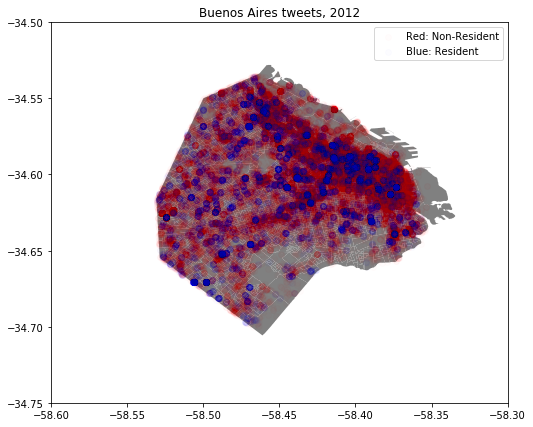

In [45]:
### Plot 5% of 2012 tweets
# Blue tweets: Resident
# Red tweets: Non-resident
# Gray (barely visible beneath the blue): Buenos Aires shapefile
fig, ax = plt.subplots(figsize=(10, 7))
ba_shapefiles['geometry'].plot(ax=ax, color='gray')
smpl = ba12_filtered[~ba12_filtered['codigo'].isnull()].sample(frac=0.05, random_state=42)
smpl[~smpl['is_home']].plot(ax=ax, marker='o', color='red', alpha=0.01, label='Red: Non-Resident')
smpl[smpl['is_home']].plot(ax=ax, marker='o', color='blue', alpha=0.01, label='Blue: Resident')
plt.legend()
plt.axis([-58.6, -58.3, -34.75, -34.5])
plt.title('Buenos Aires tweets, 2012');

In [46]:
(
    ba12_filtered
    .loc[:, ['codigo', 'is_home']]
    .groupby('codigo')
    .agg([len, np.mean])
    .rename(columns={'len':'count', 'mean':'home_tweet_ratio'})
).to_csv('../data/ba12_home_by_codigo.csv')